In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from itertools import chain
import vigra
from skimage.transform import rescale

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap

In [3]:
master

('emdata4:8900', 'f6565acc25a6405a8404191a09ee42b4')

In [4]:
from neuprint import Client
npclient = Client('emdata1.int.janelia.org:11000')

In [5]:
q = """\
    MATCH (n:`hemibrain-Neuron`)
    WHERE n.status in ["Leaves", "Prelim Roughly traced", "Roughly traced", "Traced"]
    RETURN n.bodyId as body, n.status as status
"""
bodies_df = npclient.fetch_custom(q)
print(bodies_df.shape)
display(bodies_df.head())
display(pd.DataFrame(bodies_df['status'].value_counts()))

(97586, 2)


,body,status
0,633313340,Leaves
1,851239892,Leaves
2,1963726096,Leaves
3,1880852626,Leaves
4,1342876876,Leaves


,status
Leaves,75353
Roughly traced,21561
Traced,672


In [6]:
def downsample_mask(mask, factor, method=np.logical_or.reduce):
    mask = np.asarray(mask, order='C')
    v = view_as_blocks(mask, mask.ndim*(factor,))
    
    last_axes = (*range(v.ndim),)[-mask.ndim:]
    return method(v, axis=last_axes)

In [7]:
seg_box_s6 = round_box(fetch_volume_box(*master_seg), 64*(2**6)) // 2**6
seg_box_s5 = 2*seg_box_s6

In [8]:
# Download scale 5
roi_vol_s5, roi_mask = fetch_roi(*master, 'all_brain', format='mask', mask_box=seg_box_s5)

# Downsample to scale 6
roi_vol_s6 = downsample_mask(roi_vol_s5, 2)

# Project through Y
roi_thumbnail = np.logical_or.reduce(roi_vol_s6, axis=1)

In [9]:
def rshift(x, n):
    if x >= 0:
        return (x >> n)
    else:
        return (x >> n) | 0xffff_ffff_ffff_ffff << (64-n)

In [10]:
rshift(4, 1)

2

In [11]:
from skimage.color import hsv2rgb

k1 = 0xcc9e2d51
k2 = 0x1b873593

# MurmurHash excluding the final mixing steps.
def hashCombine(state, value):
    value = (value * k1)
    value = ((value << 15) | rshift(value, 17))
    value = (value * k2)
    state = (state ^ value)
    state = ((state << 13) | rshift(state, 19))
    state = ((state * 5) + 0xe6546b64)
    return state

def SegmentColorHash_compute(x, hashSeed=0):
    h = hashCombine(hashSeed, x & 0xFFFF_FFFF);
    h = hashCombine(h, (x >> 32) & 0xFFFF_FFFF);
    c0 = (h & 0xFF) / 255;
    c1 = ((h >> 8) & 0xFF) / 255;
    hsv = (c0, 0.5 + 0.5 * c1, 1.0)
    hsv = np.asarray(hsv)
    rgb = hsv2rgb(hsv[None, None, :])[0,0]
    return rgb

In [12]:
import scipy.ndimage

def generate_thumbnail(body, roi_thumbnail, format='labels', neuron_color=[255,255,0]):
    mask, mask_box = fetch_sparsevol_coarse(*master_seg, body, format='mask', mask_box=seg_box_s6)

    # Project through Y
    mask_thumbnail = np.logical_or.reduce(mask, axis=1)

    combined_thumbnail = roi_thumbnail.copy().astype(np.uint8)
    combined_thumbnail[mask_thumbnail] = 2

    box = compute_nonzero_box(combined_thumbnail)
    combined_thumbnail = extract_subvol(combined_thumbnail, box)
    
    if format == 'labels':
        return combined_thumbnail
    
    if format == 'rgb':
        rgb = [[0,0,0], [100,100,100], neuron_color]
        rgb = np.array(rgb)
        rgb_thumbnail = np.zeros(combined_thumbnail.shape + (3,), dtype=np.uint8)
        for c in range(3):
            rgb_thumbnail[...,c] = rgb[:,c][combined_thumbnail]
        return rgb_thumbnail

def show_thumbnail(body, roi_thumbnail):
    combined_thumbnail = generate_thumbnail(body, roi_thumbnail)
    cmap = LinearSegmentedColormap.from_list('thumbnail_colors', ['black', 'gray', 'yellow'], 3)
    figure(figsize=np.array(combined_thumbnail.shape) / 40)
    p = plt.imshow(combined_thumbnail, cmap=cmap);
    return p

In [13]:
!mkdir -p thumbnails

In [18]:
def thumbnail_batch(bodies):
    bad_bodies = []
    for body in bodies:
        #color = (255*SegmentColorHash_compute(body)).astype(int)
        color = [255,255,0]
        try:
            rgb = generate_thumbnail(body, roi_thumbnail, format='rgb', neuron_color=color)
        except Exception as ex:
            bad_bodies.append(body)
            continue
        
        rgb = rescale(rgb, 1/2, anti_aliasing=True, multichannel=True)
        vigra.impex.writeImage(rgb.transpose(1,0,2), f'thumbnails/{body}.png')
    return bad_bodies

bad_bodies = compute_parallel(thumbnail_batch, iter_batches(bodies_df['body'].values, 20), processes=32, ordered=False)
bad_bodies = [*chain(*bad_bodies)]

print(f"Failed to generate thumbnails for {len(bad_bodies)} bodies.")

Failed to generate thumbnails for 9 bodies.


In [162]:
rgb.shape

(292, 269, 3)

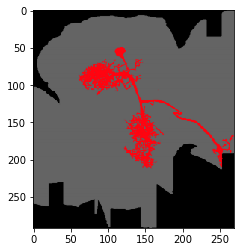

In [193]:

#body = 1790675377
#body = 664511977
body = 799868224
color = (255*SegmentColorHash_compute(body)).astype(int)

rgb = generate_thumbnail(body, roi_thumbnail, format='rgb', neuron_color=color)
rgb = rescale(rgb, 1/2, anti_aliasing=True)
vigra.impex.writeImage(rgb.transpose(1,0,2), f'{body}.png')

#figure(figsize=np.array(rgb.shape[:2]) / 40)
vigra.imshow(rgb)

In [19]:
bodies_df.query('body == 1009828654')

,body,status
32307,1009828654,Leaves


In [ ]:
for body in bodies_df['body'].tail():
    display(show_thumbnail(body, roi_thumbnail));

In [ ]:
show_thumbnail(1790675377, roi_thumbnail);

In [62]:
bodies_df.tail()

,body,status
97581,357224041,Traced
97582,829598814,Traced
97583,1790675377,Traced
97584,672598344,Traced
97585,674420122,Traced


In [20]:
pwd

'/nrs/flyem/bergs/hemibrain-release'

In [22]:
ls -ld /nrs/flyem/bergs/hemibrain-release/thumbnails/

drwxr-sr-x 2 bergs flyem 4096 Nov 25 17:02 /nrs/flyem/bergs/hemibrain-release/thumbnails//
